# Assembling data for the Hyades

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from tqdm import tqdm

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [3]:
def convert_hours_to_degrees(df, ra_name, dec_name):
    RA, DE = [], [] #[np.zeros(len(douglas)) for i in range(2)]
    for i in range(len(df)):     
        coords = "{0} {1}".format(df[ra_name].values[i], df[dec_name].values[i])
        c = SkyCoord(coords, unit=(u.hourangle, u.deg))
        RA.append(c.ra.degree)
        DE.append(c.dec.degree)
    df["ra"] = RA
    df["dec"] = DE
    return df

Combine Douglas, Delorme and Radick (still need to add Hartman, Prosser and ASAS).

In [5]:
douglas = pd.read_csv("../data/hyades.csv")
delorme = pd.read_csv("../data/hyades_delorme.csv", skiprows=70)
radick87= pd.read_csv("../data/hyades_radick_1987.csv")
radick95= pd.read_csv("../data/hyades_radick_1995.csv")
hartman = pd.read_csv("../data/hartman.csv", skiprows=76)

hartman = convert_hours_to_degrees(hartman, "RAJ2000", "DEJ2000")

radick87.head()

,number,B-V,period,period_err,RAJ1950,decJ1950
0,VB 65,0.535,5.87,0.03,4 24 45,15 28 43
1,VB 59,0.543,5.13,0.02,4 23 15,15 24 44
2,VB 31,0.566,5.45,0.02,4 17 18,19 6 54
3,VB 52,0.597,8.05,0.06,4 21 36,16 46 19
4,VB 50,0.601,7.10,0.05,4 21 22,14 38 38


In [8]:
from astropy.coordinates import FK5

RAJ2000, DEJ2000 = [], []
for i in range(len(radick87)):
    coord = SkyCoord(radick87.RAJ1950.values[i], radick87.decJ1950.values[i], 
                     unit=(u.hourangle, u.deg), equinox="J1950")
    rd = coord.transform_to(FK5(equinox='J2000'))
    RAJ2000.append(rd.ra.degree)
    DEJ2000.append(rd.dec.degree)

radick87["RAJ2000"] = np.array(RAJ2000)
radick87["DEJ2000"] = np.array(DEJ2000)

Load the gaia crossmatch for the clusters.

In [9]:
gaia = pd.read_csv("../data/gaia_cluster_crossmatch.csv", skiprows=49)
m = gaia.Cluster.values == "Hyades  "
hg = gaia.iloc[m]
hg.head()

,Source,Cluster,RA_ICRS,DE_ICRS,Gmag,plx,e_plx,_RA.icrs,_DE.icrs
0,49520255665123328,Hyades,64.87461,21.75372,12.861,20.866,0.033,64.87461,21.75372
1,49729231594420096,Hyades,60.20378,18.19388,5.790,21.789,0.045,60.20378,18.19388
2,51383893515451392,Hyades,59.80696,20.42805,12.570,22.737,0.006,59.80696,20.42805
3,145373377272257664,Hyades,66.06127,21.73605,6.990,23.109,0.003,66.06127,21.73605
4,145391484855481344,Hyades,67.00371,21.61972,5.643,19.968,0.067,67.00371,21.61972


And Megan Bedell's K2 - Gaia crossmatch.

In [10]:
bedell = pd.read_csv("K2_c4_gaia.csv")

(-1, 36)

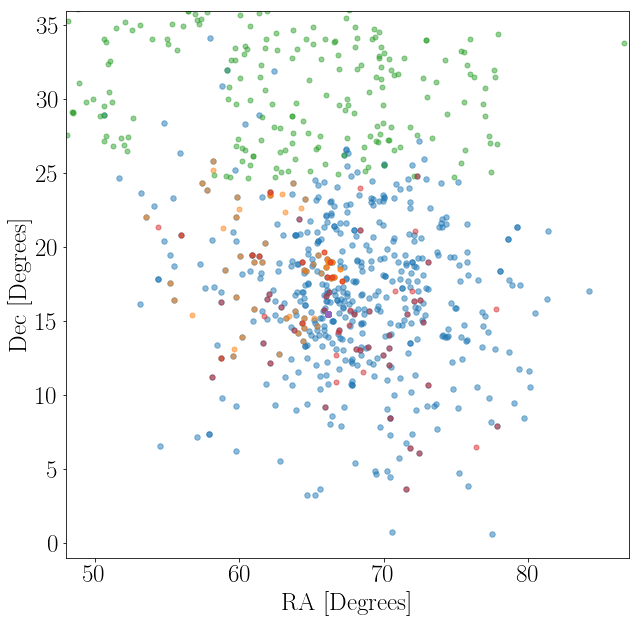

In [135]:
f = .3
width, height = (max(hg.RA_ICRS) - min(hg.RA_ICRS)), (max(hg.DE_ICRS) - min(hg.DE_ICRS))
plt.figure(figsize=(width*f, height*f))
plt.scatter(hg.RA_ICRS, hg.DE_ICRS, s=30, zorder=0, alpha=.5)
plt.scatter(douglas.ra, douglas.dec, s=25, zorder=1, alpha=.5)
plt.scatter(hartman.ra, hartman.dec, s=25, zorder=2, alpha=.5)
plt.scatter(delorme._RA, delorme._DE, s=25, zorder=3, alpha=.5)
plt.scatter(radick87.RAJ2000, radick87.DEJ2000, zorder=4, alpha=.5)
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)

Find closest matches between Gaia and other catalogues.

In [87]:
def find_min_dist(ra1, dec1, ra2, dec2, dist_arcsecs=5.):
    """
    ind1 is a list of indices the same length as ra1 and dec1 that identifies matching stars in ra1 and dec1.
    ind2 is a list of indices the same length as ra2 and dec2 that identifies matching stars in ra2 and dec2.
    """
    closest_ra, closest_dec, distance, ind1, ind2 = [], [], [], [], []
    for i in tqdm(range(len(ra1))):
        e2 = np.sqrt((ra2.values - ra1.values[i])**2 + (dec2.values - dec1.values[i])**2)
        min_distance = min(e2)
        if min_distance < dist_arcsecs/3600.:
            m = e2 == min_distance
        if sum(m) > 1:
            closest_ra.append(ra2.values[i])
            closest_dec.append(dec2.values[i])
            distance.append(min_distance)
            ind1.append(i)
            ind2.append(np.arange(len(ra2))[m[0]])
        elif sum(m) > 0:
            closest_ra.append(float(ra2.values[m]))
            closest_dec.append(float(dec2.values[m]))
            distance.append(min_distance)
            ind1.append(i)
            ind2.append(np.arange(len(ra2))[m])
    return np.array(distance), np.array(closest_ra), np.array(closest_dec), np.array(ind1), np.array(ind2)

# Gaia and Hartman

In [88]:
hartman.head()

,HAT,n_HAT,pmRA,pmDE,Jmag,Hmag,Kmag,Vmag,r_Vmag,Pe,...,dR.t1,dR.t2,Qt,N,2M,Simbad,RAJ2000,DEJ2000,ra,dec
0,086-0001701,,35.13,-36.72,9.519,8.763,8.658,12.136,1,,...,0.010,0.005,0,2,2M,Simbad,00 13 38.42,+52 45 05.0,3.410083,52.751389
1,086-0004017,,35.30,35.51,9.565,8.804,8.643,12.235,1,40.868328,...,,,2,2,2M,Simbad,23 54 23.85,+54 41 26.9,358.599375,54.690806
2,086-0005153,,76.13,-7.77,9.906,9.239,9.060,12.822,1,16.368924,...,,,2,4,2M,Simbad,23 51 18.20,+54 35 16.2,357.825833,54.587833
3,086-0005542,,146.68,-27.87,9.980,9.349,9.137,12.767,1,20.363047,...,0.010,0.009,0,3,2M,Simbad,00 16 56.01,+50 37 49.0,4.233375,50.630278
4,086-0005602,x,-83.81,51.47,10.008,9.409,9.186,12.870,1,,...,0.016,0.009,1,0,2M,Simbad,00 16 01.61,+48 55 56.9,4.006708,48.932472


(-1, 36)

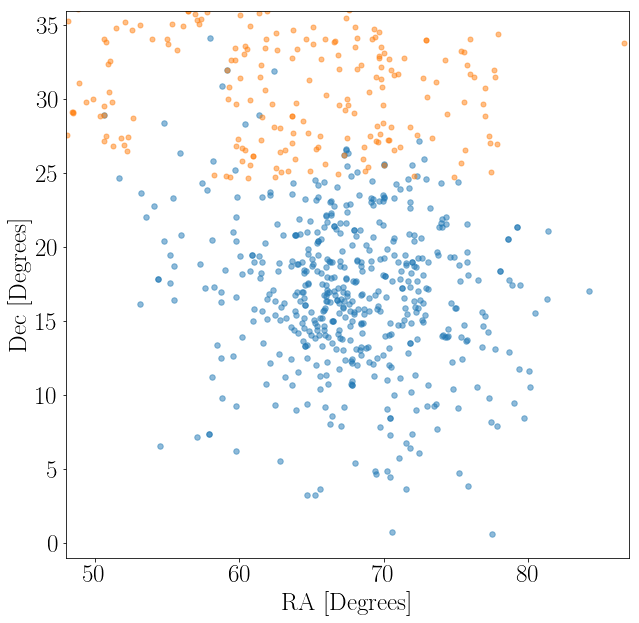

In [89]:
f = .3
width, height = (max(hg.RA_ICRS) - min(hg.RA_ICRS)), (max(hg.DE_ICRS) - min(hg.DE_ICRS))
plt.figure(figsize=(width*f, height*f))
plt.scatter(hg.RA_ICRS, hg.DE_ICRS, s=30, zorder=0, alpha=.5)
plt.scatter(hartman.ra, hartman.dec, s=25, zorder=1, alpha=.5)
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)

Find the closest stars

In [83]:
distance, closest_ra, closest_dec, m, inds = find_min_dist(hg.RA_ICRS, hg.DE_ICRS, hartman.ra, hartman.dec)
print(sum(m), "matches")


100%|██████████| 515/515 [00:03<00:00, 157.67it/s]

4 matches


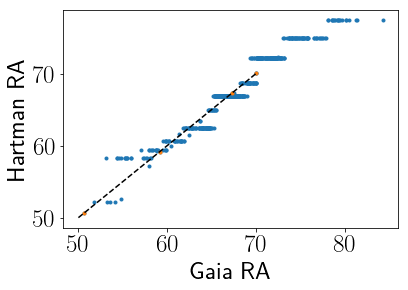

In [84]:
plt.plot(hg.RA_ICRS.values, closest_ra, ".")
plt.plot(hg.RA_ICRS.values[m], closest_ra[m], ".")
plt.xlabel("Gaia RA")
plt.ylabel("Hartman RA")
xs = np.linspace(50, 70, 100)
plt.plot(xs, xs, "--k")

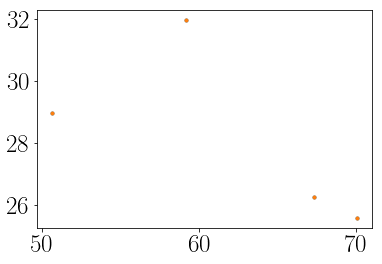

In [85]:
plt.plot(hg.RA_ICRS[m], hg.DE_ICRS[m], ".")
plt.plot(closest_ra[m], closest_dec[m], ".")

In [86]:
print(inds)

[1889 1873 1873 1887 1887 1887 1887 1887 1887 1887 1887 1887 1887 1887
 1887 1894 1895 1895 1895 1887 1892 1887 1894 1892 1579 1579 1895 1895
 1895 1579 1873 1892 1887 1887 1895 1887 1889 1889 1889 1879 1882 1875
 1873 1889 1887 1889 1895 1887 1887 1892 1875 1875 1887 1882 1895 1895
 1875 1873 1875 1873 1873 1875 1873 1895 1894 1896 1894 1894 1874 1882
 1894 1895 1894 1895 1895 1895 1895 1895 1895 1895 1895 1895 1895 1887
 1875 1887 1875 1887 1887 1875 1875 1887 1887 1887 1895 1895 1895 1887
 1892 1879 1895 1896 1896 1887 1887 1887 1887 1875 1875 1875 1875 1875
 1875 1875 1875 1875 1887 1887 1892 1892 1895 1895 1887 1887 1887 1887
 1894 1894 1882 1887 1875 1875 1875 1895 1892 1889 1887 1875 1875 1875
 1887 1887 1875 1889 1896 1894 1894 1896 1896 1887 1892 1882 1882 1874
 1895 1895 1895 1895 1895 1895 1875 1875 1874 1894 1895 1887 1887 1887
 1887 1887 1887 1887 1887 1887 1887 1887 1875 1887 1875 1875 1873 1873
 1875 1894 1894 1894 1896 1896 1887 1887 1887 1887 1887 1887 1887 1887
 1887 

Now try the EPIC catalogue.

In [76]:
# distance, closest_ra, closest_dec, m, inds = find_min_dist(hartman.ra, hartman.dec, bedell.ra, bedell.dec)

In [77]:
# plt.plot(hartman.ra, closest_ra, ".")
# print(sum(m), "matches")
# plt.plot(hartman.ra.values[m], closest_ra[m], ".")
# plt.xlabel("Gaia RA")
# plt.ylabel("Hartman RA")
# xs = np.linspace(50, 70, 100)
# plt.plot(xs, xs, "--k")

Now add the Hartman catalogue on to the Douglas catalogue.

In [33]:
df1 = pd.concat((douglas, hartman.iloc[m]))
print(np.shape(douglas), np.shape(hartman), np.shape(df1))

(73, 36) (2033, 24) (77, 56)


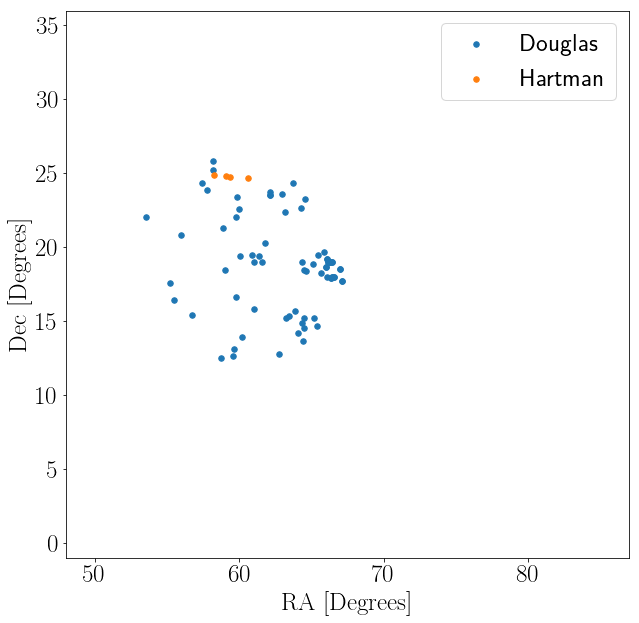

In [38]:
plt.figure(figsize=(width*f, height*f))
plt.scatter(df1.iloc[:73].ra, df1.iloc[:73].dec, s=30, zorder=0, label="Douglas")
plt.scatter(df1.iloc[73:].ra, df1.iloc[73:].dec, s=30, zorder=1, label="Hartman")
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)
plt.legend()

# Gaia and Delorme

In [34]:
delorme.head()

,SWASP,X,Per,J-Ks,Ksmag,Vmag,Dist,pmRA,e_pmRA,pmDE,e_pmDE,plx,Mmb,SpType,Vmagl,B-Vl,Ref,SimbadName,_RA,_DE
0,J033734.97+212035.4,Yes,10.57,0.524,7.12,9.30,12.4,141.5,1.7,-27.3,1.3,25.18,1.0,G5,9.36,0.92,2,Melotte 25 5,54.39571,21.34317
1,J034347.07+205136.4,No,12.30,0.871,9.61,,10.9,140.0,1.0,-32.0,1.0,,1.0,,14.54,0.90,4,,55.94612,20.86011
2,J035234.31+111538.6,No,13.29,0.858,9.01,,10.2,166.0,15.0,-10.0,1.0,,1.0,M,13.73,1.54,2,,58.14296,11.26072
3,J035453.20+161856.3,Yes,6.04,0.905,9.06,,7.7,130.0,2.0,-18.0,2.0,,1.0,M,14.25,1.58,2,,58.72167,16.31564
4,J035501.43+122908.1,,11.66,0.607,7.57,10.00,8.9,127.5,2.1,-9.6,1.5,25.62,1.0,M0,10.12,1.07,1,Cl* Melotte 25 S 155,58.75596,12.48558


(-1, 36)

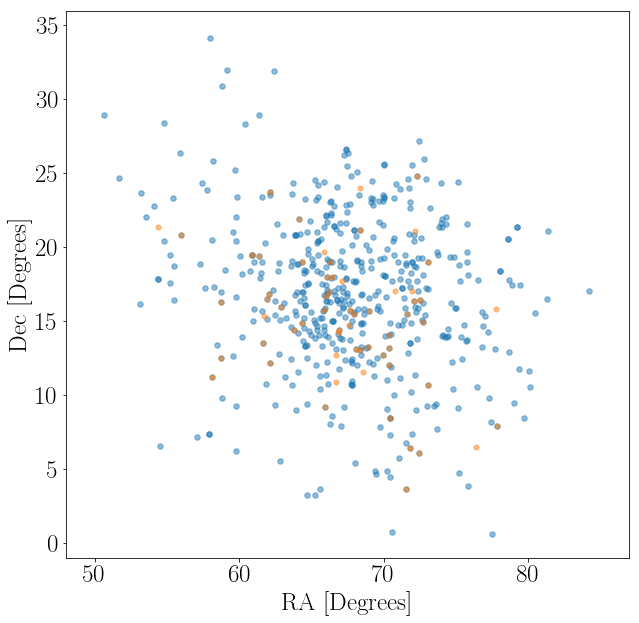

In [36]:
f = .3
width, height = (max(hg.RA_ICRS) - min(hg.RA_ICRS)), (max(hg.DE_ICRS) - min(hg.DE_ICRS))
plt.figure(figsize=(width*f, height*f))
plt.scatter(hg.RA_ICRS, hg.DE_ICRS, s=30, zorder=0, alpha=.5)
plt.scatter(delorme._RA, delorme._DE, s=25, zorder=1, alpha=.5)
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)

Find the closest stars.

In [65]:
distance, closest_ra, closest_dec, m = find_min_dist(delorme._RA, delorme._DE, hg.RA_ICRS, hg.DE_ICRS)
print(sum(m), "matches")

100%|██████████| 62/62 [00:00<00:00, 393.59it/s]

45 matches


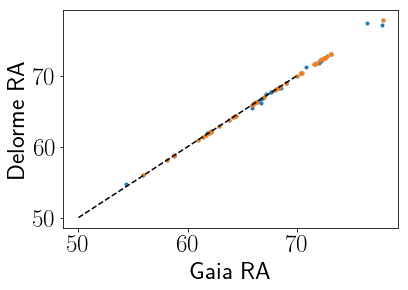

In [66]:
plt.plot(delorme._RA, closest_ra, ".")
plt.plot(delorme._RA.values[m], closest_ra[m], ".")
plt.xlabel("Gaia RA")
plt.ylabel("Delorme RA")
xs = np.linspace(50, 70, 100)
plt.plot(xs, xs, "--k")

Add Delorme to the catalogue.

In [71]:
df2 = pd.concat((df1, delorme.iloc[m]))
print(np.shape(df1), np.shape(delorme.iloc[m]), np.shape(df2))
print(delorme._DE.values[m])

(77, 56) (45, 20) (122, 73)
[20.86011 11.26072 16.31564 12.48558 19.45503 19.44214 13.54911 16.51878
 16.87314 12.19183 23.76861 15.99217 14.39847 21.90744 19.02983 14.90108
 15.76311  9.20542 16.72158 18.00289 16.98494 18.97358 14.41772 15.49953
 13.11322 13.04544 21.15083 13.28806 15.684   12.72847 14.07614 12.00936
 13.22119  8.43889  3.63631 15.47203  6.45322 16.38861 24.80283  6.10933
 16.41208 14.97125 18.99692 10.71942  7.90889]


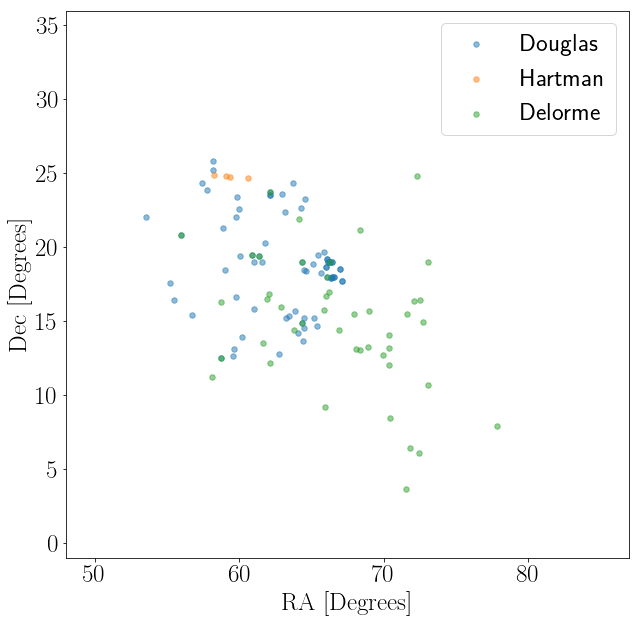

In [73]:
plt.figure(figsize=(width*f, height*f))
plt.scatter(df2.iloc[:73].ra, df2.iloc[:73].dec, s=30, zorder=0, alpha=.5, label="Douglas")
plt.scatter(df2.iloc[73:77].ra, df2.iloc[73:77].dec, s=30, zorder=1, alpha=.5, label="Hartman")
plt.scatter(df2.iloc[77:122]._RA, df2.iloc[77:122]._DE, s=30, zorder=2, alpha=.5, label="Delorme")
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)
plt.legend()